In [1]:
import nltk
import random
import numpy as np
import pandas as pd

d:\softwares\Python\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\softwares\Python\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
d:\softwares\Python\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\softwares\Python\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
d:\softwares\Python\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from nltk.corpus import gutenberg
from nltk.corpus import stopwords
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# get the book list
bookList = gutenberg.fileids()
print(bookList)

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [4]:
books = np.array(bookList[3])
# books = np.append(books, bookList[3])
books = np.append(books, bookList[4])
books = np.append(books, bookList[6])
books = np.append(books, bookList[7])
books = np.append(books, bookList[11])
books = np.append(books, bookList[13])
books = np.append(books, bookList[15])

In [5]:
def sampling(number_samples, sample_size, book_name):
    labeled_records = []
    book = gutenberg.raw(book_name)
    # print(book)
    # tokenize the material of the book
    raw_words = nltk.word_tokenize(book)
    # print(raw_words)
    # Prepare 200 documents for each book
    headers = random.sample(range(0, len(raw_words)), number_samples)

    for header in headers:
        segment = raw_words[header:(header + sample_size + 1)]
        labeled_records.append((segment, book_name))
    return labeled_records

In [6]:
from string import punctuation
from nltk.corpus import gutenberg
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
def data_cleaning(sample_words):
    # customize the punctuation list by adding extra string
    extra_string = "'-- ``'' "
    update_punctuation = punctuation + extra_string
    # customize the stopwords list by adding extra stopwords
    sw = stopwords.words('english')
    extra_stopwords = "n't", "'s", "ar't", "'d", "'ll", "i'll"
    sw.extend(extra_stopwords)
    # Remove punctuation
    remove_punct_words = [w for w in sample_words if w not in update_punctuation]
    # Change all letters to lowercase
    lowercase_words = [w.lower() for w in remove_punct_words]
    # Strip "_" at the beginning or end of a word
    strip_words = [w.strip('_') for w in lowercase_words]
    # Remember digits/numbers (keeps only words)
    remove_number_words = [w for w in strip_words if w.isalpha()]
    # Remove stop words
    final_words = [w for w in remove_number_words if w not in sw]
    return final_words

In [8]:
if __name__ == "__main__":
    try_number_samples = 200
    try_sample_size = 150
    final_list = []
    for book_name in books:
        # print (book_name)
        labeled_list = sampling(try_number_samples, try_sample_size, book_name)
        cleaned_labeled_list = []

        for samples in labeled_list:
            book_name = samples[1]

            cleaned_seg = data_cleaning(samples[0])
            cleaned_labeled_seg = (cleaned_seg, book_name)
            # print(cleaned_labeled_seg)
            cleaned_labeled_list.append(cleaned_labeled_seg)
        # print(cleaned_labeled_list)
        final_list = final_list + cleaned_labeled_list
    # shuffle the list
#     shuffle(final_list)
    #print(final_list)

    docs = []
    tags = []

    # word lemmatization
    lem = WordNetLemmatizer()
    for labeled_doc in final_list:
        docs.append(lem.lemmatize(' '.join(labeled_doc[0])))
        tags.append(labeled_doc[1])
#     print(docs)
    # import data to dictionary
    dic = {'Text': docs, 'File_name': tags}
    # apply pandas data frame
    df = pd.DataFrame(dic)
#     print(df)
    # df.columns = ['Text', 'File_name']
    df['book_id'] = df['File_name'].factorize()[0]
    book_id_df = df[['File_name', 'book_id']].drop_duplicates().sort_values('book_id')
    book_to_id = dict(book_id_df.values)
    id_to_book = dict(book_id_df[['book_id', 'File_name']].values)
    
    # feature engineering： TF-IDF
#     tfidf = TfidfVectorizer(sublinear_tf=True, encoding='latin-1', ngram_range=(1, 2), stop_words='english')
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer()
    features = vectorizer.fit_transform(df['Text'])
#     print(features)

In [9]:
# Hierarchy clustering
# Training the Hierarchical Clustering model on the dataset
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(features.toarray())

print(len(y_hc))
print(y_hc)
hc.n_clusters_

1400
[3 3 0 ... 2 2 2]


7

In [10]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(features.toarray())

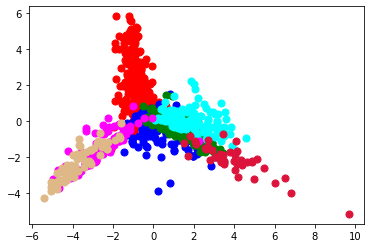

In [11]:
# Visualising the clusters
import matplotlib.pyplot as plt
plt.scatter(Y_sklearn[y_hc == 0, 0], Y_sklearn[y_hc == 0, 1], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(Y_sklearn[y_hc == 1, 0], Y_sklearn[y_hc == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(Y_sklearn[y_hc == 2, 0], Y_sklearn[y_hc == 2, 1], s = 50, c = 'green', label = 'Cluster 3')
plt.scatter(Y_sklearn[y_hc == 3, 0], Y_sklearn[y_hc == 3, 1], s = 50, c = 'cyan', label = 'Cluster 4')
plt.scatter(Y_sklearn[y_hc == 4, 0], Y_sklearn[y_hc == 4, 1], s = 50, c = 'magenta', label = 'Cluster 5')
plt.scatter(Y_sklearn[y_hc == 5, 0], Y_sklearn[y_hc == 5, 1], s = 50, c = 'crimson', label = 'Cluster 6')
plt.scatter(Y_sklearn[y_hc == 6, 0], Y_sklearn[y_hc == 6, 1], s = 50, c = 'burlywood', label = 'Cluster 7')
plt.show()

In [12]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
print(homogeneity_score(df.File_name, hc.labels_))
silhouette_score(features, labels=hc.labels_)

0.5977479222539811


0.015463186213173488

In [13]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(df.book_id, y_hc)

0.00666666666666671